## Filtros Resposta Infinita ao Impulso

Vamos denominar Infinite Response Impulse Reponse (IIR) os filtros que são caracterizados pelas equações:
$$ y(n) = \sum_{k=0}^{N-1}b_k x(n-k) - \sum\limits_{k=1}^M a_k y(n-k)$$
$$ H(z) = \frac{\sum_\limits{k=0}^{N-1}b_kz^{-k}}{1 + \sum\limits_{k=1}^{M}a_kz^{-k}}$$
sendo $b_k$ e $a_k$ os coeficientes que definem o filtro. 

Características:
1. A saída atual depende das entradas atual e anteriores, e das saída anteriores;
2. Filtros IIR nem sempre são estáveis;
3. Não há garantia de fase linear;

Dadas as especificações do filtro (tipo, tolerâncias nas bandas de passagem e rejeição), deve-se utilizar um método para determinar os coeficientes. Alguns desses métodos serão explorados a seguir.

### <font color='blue'> Método do cálculo pelo posicionamento de pólos e zeros </color>

O posicionamento dos pólos e zeros no plano $z$ modificam a resposta em frequência do sistema, considerando uma função genérica
$$ H(z) = \frac{(z-o_1)(z-o_2)...(z-o_M)}{(z-p_1)(z-p_2)...(z-p_m)}
$$
sendo $o_i$ $i$-ésimo zero, e $p_j$ o $j$-ésimo polo, e que para analisar a resposta em frequência do filtro fazemos $z = e^{j\omega}$, temos que:
- ao se aproximar de um zero $o_i$ o módulo de $H(e^{j\omega})$ decresce, produzindo um vale (nulo);
- ao se aproxima de um pólo $p_i$, $|H(e^{j\omega})|$ aumenta, produzindo um pico, e;
- zeros e polos próximas anulam os efeitos um do outro.
Na figura abaixo estes fatos estão representados.

![title](img/Fig83Ifeachor.png)


Deve-se levar em conta que para que os coeficiente do filtros sejam número reais (isso facilita a implementação), os pólos e zero devem ser reais ou ocorrerem em pares conjugados complexos.

Sistemas IIR tem a realimentação como uma duas suas caracteríticas. Assim, sendo $y(n) = b_0x(n) + a_0y(n-1)$, temos que
$$
Y(z) = b_0X(z) - a_0Y(z) z^{-1}
$$
e
$$
X(z) = \frac{Y(z)}{X(z)} = \frac{b_0 + b_1z^{-1} + b_1}{1 - a_0 z^{-1}} = \frac{b_0z}{z - a_0}
$$
ou seja, há pelo menos um zero e um pólo.

Vamos avaliar o que acontece quando variamos $a_0$ ou $b_0$. Para tanto, lembremos que a transformada de Fourier pode ser obtida da transformada z faendo $z = e^{j\omega}$, e para generalizar nossa análise vamos escrever
$$ H(z) = \frac{b_0 + b_1z^{-1}}{1 - a_0 z^{-1}}$$ apenas para incluir um zero em $o = \frac{b_1}{b_0}$ e um pólo $p = a_0$.

Como primeiro caso, seja $a_0 = 1$ e $b_0 = 1$, variando $b_1$ mudamos a posição do zero.

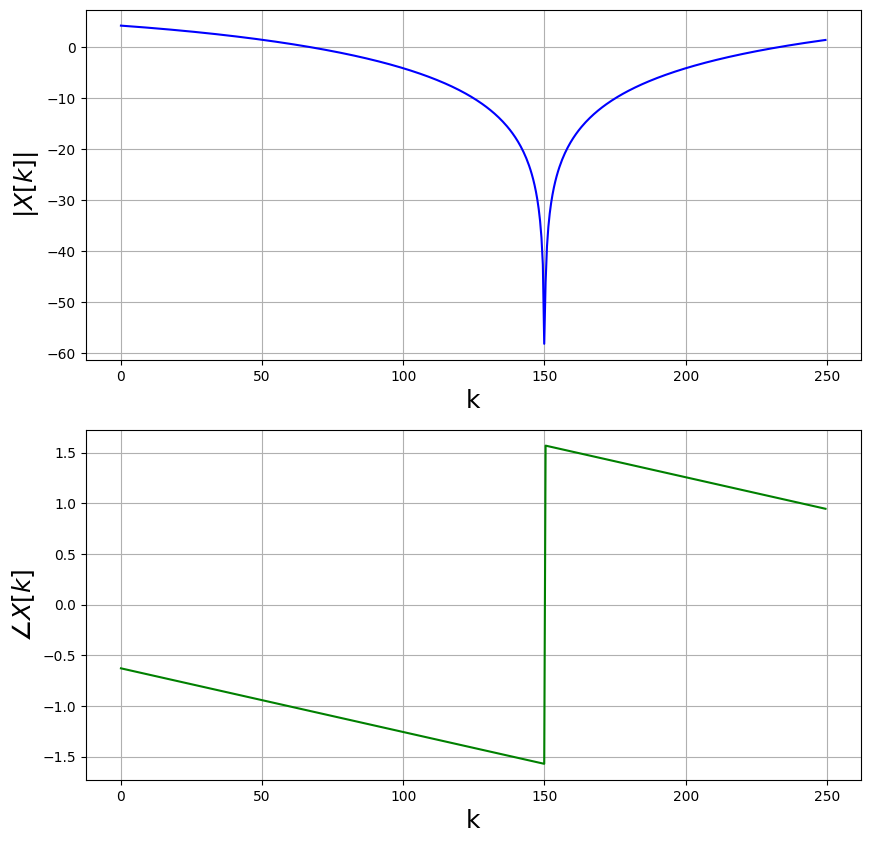

In [7]:
## Aloca zeros e polos conforme especificado e desenha o módulo e a fase da resposta
#  em frequência.
#
# Usa a função        b_0 + b_1z^{-1} + ... + b_{N}z^{N} 
#             H(z) = ---------------------------------------
#                     1 + a_1z^{-1} + a_2z^{-2} + ... + b_{M}z^{M}
#
#
# Edmar C. Gurjão - 30/05/2023

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy as scp

# Frequência de amostragem
fs = 500

# Frequência en Hz onde se deseja um zero

f_zero = 150

b_1 = np.cos(f_zero*2*np.pi/500) + 1j*np.sin(f_zero*2*np.pi/500)


b = [1, -b_1]
a = [1]

w,Hk = signal.freqz(b,a,fs=2*np.pi) # resposta em frequência


# Converte o zetor w = [0, pi] para Hz 
wf = w*250/np.pi

fig,ax=plt.subplots(2)
fig.set_size_inches((10,10))

ax[0].plot(wf, 20 * np.log10(abs(Hk)), 'b')
ax[0].set_xlabel('k',fontsize=18)
ax[0].set_ylabel(r'$|X[k]|$',fontsize=18)
ax[0].grid()

angles = np.unwrap(np.angle(Hk))
ax[1].plot(wf, angles, 'g')
ax[1].set_xlabel('k',fontsize=18)
ax[1].set_ylabel(r'$\angle X[k]$',fontsize=18)
ax[1].grid()

Como segund caso, seja $b_1 = -1$ (zero em Fs/2 no exemplo), e $b_0 = 1$, variando $a_0$ mudamos a posição do polo.

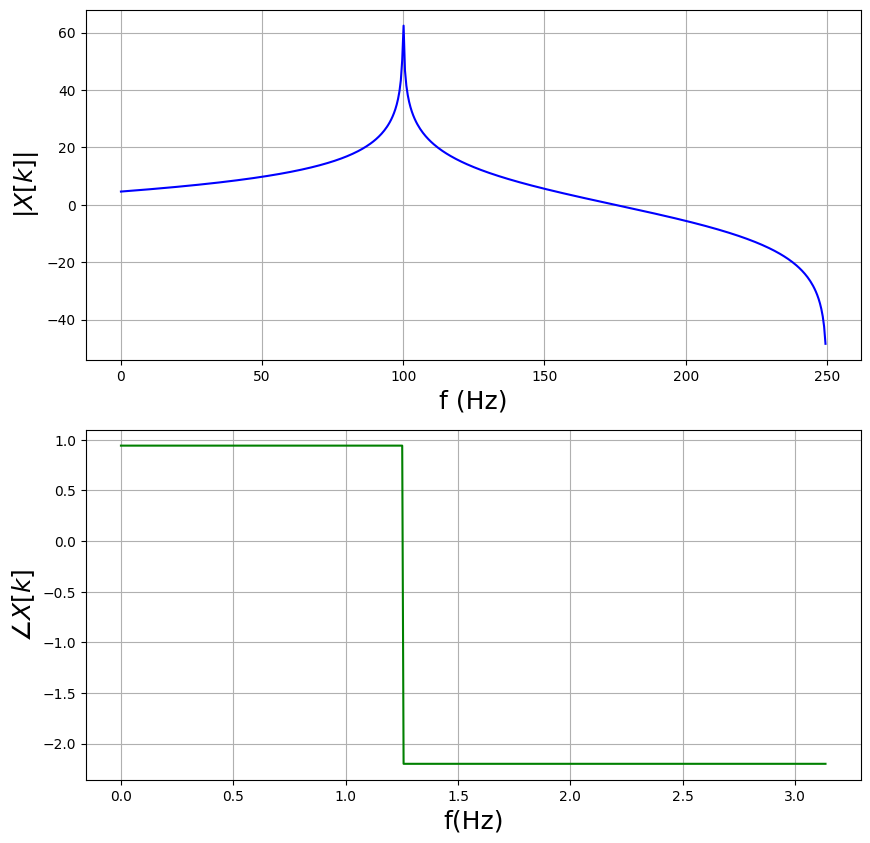

In [91]:
## Aloca zeros e polos conforme especificado e desenha o módulo e a fase da resposta
#  em frequência.
#
# Usa a função        b_0 + b_1z^{-1} + ... + b_{N}z^{N} 
#             H(z) = ---------------------------------------
#                     1 + a_1z^{-1} + a_2z^{-2} + ... + b_{M}z^{M}
#
#
# Edmar C. Gurjão - 30/05/2023

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy as scp

# Frequência de amostragem
fs = 500

# Frequência en Hz onde se deseja um zero

f_zero = 250

b_1 = np.cos(f_zero*2*np.pi/500) + 1j*np.sin(f_zero*2*np.pi/500)

f_polo = 100
a_1 = np.cos(f_polo*2*np.pi/500) + 1j*np.sin(f_polo*2*np.pi/500)


b = [1, -b_1]
a = [1, -a_1]

w,Hk = signal.freqz(b,a,fs=2*np.pi) # resposta em frequência


# Converte o zetor w = [0, pi] para Hz 
wf = w*250/np.pi

fig,ax=plt.subplots(2)
fig.set_size_inches((10,10))

ax[0].plot(wf, 20 * np.log10(abs(Hk)), 'b')
ax[0].set_xlabel('f (Hz)',fontsize=18)
ax[0].set_ylabel(r'$|X[k]|$',fontsize=18)
ax[0].grid()

angles = np.unwrap(np.angle(Hk))
ax[1].plot(w, angles, 'g')
ax[1].set_xlabel('f(Hz)',fontsize=18)
ax[1].set_ylabel(r'$\angle X[k]$',fontsize=18)
ax[1].grid()

<StemContainer object of 3 artists>

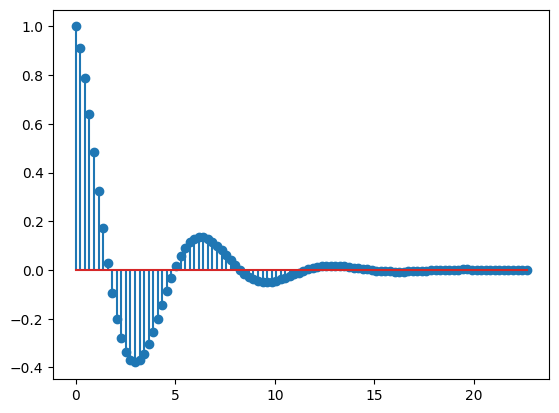

In [8]:
system = ([a, b])
t, y = signal.impulse(system)
import matplotlib.pyplot as plt
plt.stem(t, y)

Vamos considerar um filtro passa-faixas com as seguintes especificações:

1. Rejeição em DC e 250 Hz;
2. Faixa de passagem centrada em 125 Hz;
3. Largura de banda de 3dB de 10 Hz;
4. Frequência de amostragem de 500 Hz.

Primeiro precisamos determinar onde colocar os pólos e os zeros:

1. Rejeição em DC colocaremos um zero em $0^o$, para 250 Hz em $360^o \times 250/500 = 180^o$, ambas sobre o círculo unitário.
2. Para a banda de passagem faremos $\pm 360^{o} \times 125/500 = \pm 90^{o}$, que devem ser complexos conjugados. O raio $r$ onde os pólos serão colocados depende da banda de passagem desejada, e pode ser aproximado por $$r \approx 1 - (BW/Fs)\pi,$$ e para o problema chega-se a $r = 0,937$.

Por inspeção podemos escrever
$$ H(z) = \frac{(z-1)(z+1)}{(z - re^{j\pi/2})(z - re^{-j\pi/2})} = \frac{z^2 -1}{z^2 + 0,877969} = \frac{1 - z^{-2}}{1 + 0,877969z^{-2}}.$$

Que pode ser implementada em uma estrutura como está representada na Figura abaixo.

![title](img/fig84Ifeachor.png)

Alguns software necessitam quem sejam informados os coefcientes do filtro no formato $b_k$ e $a_k$. Inspecionando a função de transferência $H(z)$ chegamos a:
1. $b_0 = 1$, $b_1 = 0$, $b_2 = -1$;
2. $a_1 = 0$, $a_2 = -0,877969$.

**Link para o código abaixo:** https://colab.research.google.com/drive/1WMAtaeZLXO-sVSR1hiIRbWtjieCDdUQX?usp=sharing

/var/folders/ty/wb475mtj7c1gg_sk5ngbbnxr0000gn/T/ipykernel_50219/957261854.py:20: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(wf, 20 * np.log10(abs(Hk)), 'b')


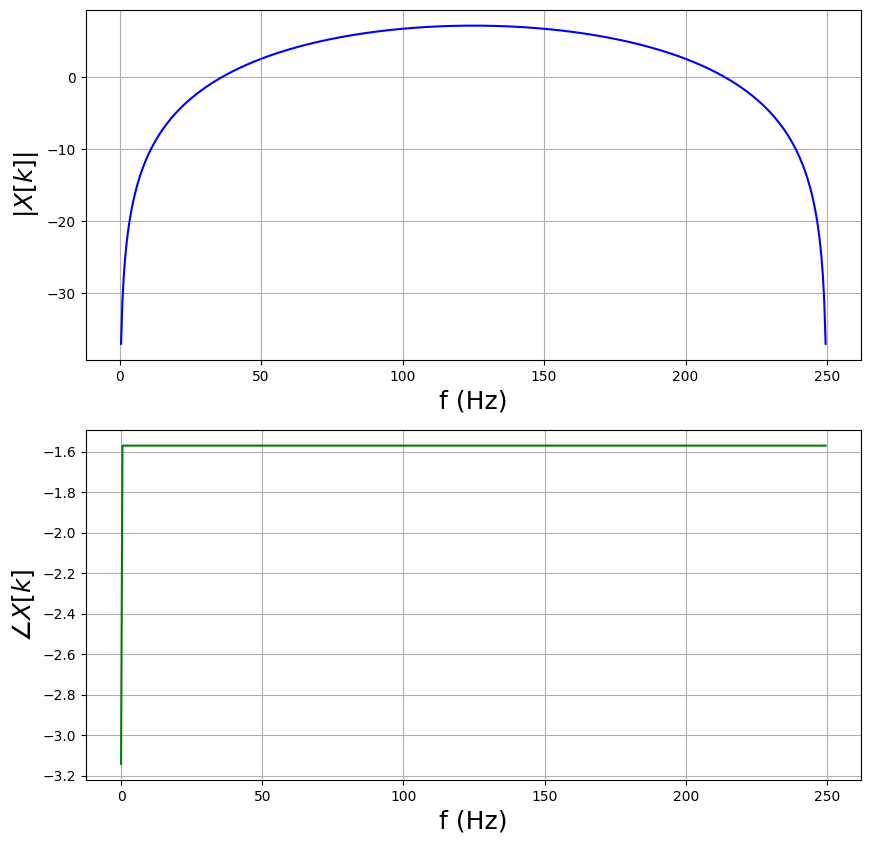

In [89]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy as scp

fs = 500

b = [1, 0, -1]
a = [0, -0.877696]

w,Hk = signal.freqz(b,a) # resposta em frequência

fig,ax=plt.subplots(2)
fig.set_size_inches((10,10))

# Converte o zetor w = [0, pi] para Hz 
wf = w*250/np.pi

ax[0].plot(wf, 20 * np.log10(abs(Hk)), 'b')
ax[0].set_xlabel('f (Hz)',fontsize=18)
ax[0].set_ylabel(r'$|X[k]|$',fontsize=18)
ax[0].grid()

angles = np.unwrap(np.angle(Hk))
ax[1].plot(wf, angles, 'g')
ax[1].set_xlabel('f (Hz)',fontsize=18)
ax[1].set_ylabel(r'$\angle X[k]$',fontsize=18)
ax[1].grid()

### <font color='blue'> Método do cálculo pela invariância ao impulso </color>

Busca transformar um função do tempo contínuo $h_c(t)$ para outra no tempo discreto $$h(n) = T_dh_c(nT_d),$$ sendo $T_d$ o intervalo de amostragem. Na frequência $$H(e^{j\omega}) = \sum_{k=-\infty}^{\infty}H_c\left(j\frac{\omega}{T_d} + j\frac{2\pi}{T_d}k\right)$$

Porém no tempo contínuo 
1. $H_c(j\Omega) = 0,\ |\Omega| \geq \pi/T_d$, e 
2. $H(e^{j\omega}) = H_c\left(j\frac{\omega}{T_d}\right),\ |\omega| \leq \pi$.

Como os filtros no tempo contínuo não podem ser limitados em frequência, sempre ocorrerá aliasing, como representado abaixo.  

![title](img/figOppenheim1.png)

Apesar de aliasing, esse método pode ser utilizado para filtros passa-baixas.

Para fazer a transformação vamos partir de $$H_c(s) = \sum_{k=1}^{N}\frac{A_k}{s-s_k},$$ que corresponde a $$h_c(t) = \left\{\begin{array}{c c} \sum\limits_{k=1}^{N}A_ke^{s_kt},& t\geq 0 \\ 0& t < 0 \end{array}\right.$$ 

Temos que 
$$ h(n) = T_dh_c(nT_d) = \sum\limits_{k=1}^{N}T_d A_k e^{s_k nT_d}u(n) = \sum\limits_{k=1}^{N}T_d A_k (e^{s_kT_d})^n u(n)$$
então
$$H(z) = \sum\limits_{k=1}^{N} \frac{T_d A_k}{1 - e^{s_k T_d}}$$

Podemos resumir o projeto pela invariância ao impulso pelas seguintes etapas:
1. Especificar o filtro desejado em termos da frequência ($\omega$);
2. Obter as especificações de filtro analógico $(H_c(j\Omega))$ usando a relação $\Omega = \frac{\omega}{T}$;
3. Mapear:
$$ H_c(s) = \sum\limits_{k=1}^{N} \frac{A_k}{s - s_k} \rightarrow H(z) = \sum\limits_{k=1}^{N} \frac{T_d A_k}{1 - e^{T_d s_k}z^{-1}}$$

**Exemplo:** Sejam as especificações: 
1. $ 0,89125 \leq |H(e^{j\omega})| \leq 1,\ 0 \leq |\omega| \leq 0.2\pi$
2. $|H(e^{j\omega})| \leq 0.17783,\ 0.3\pi \leq |\omega| \leq \pi$
e um filtro Butterwolf.

Considerando $T_d = 1$, temos $\omega = \Omega$ e o mapeamento entre frequências fica
1. $ 0,89125 \leq |H_c(j\Omega)| \leq 1,\ 0 \leq |\Omega| \leq 0.2\pi$
2. $|H_c(j\Omega)| \leq 0.17783,\ 0.3\pi \leq |\Omega| \leq \pi$

Aplicando essas restrições a um filtro Butterwolf cuja resposta em frequência é dada por $$|H_c(j\Omega)|^2 = \frac{1}{1 + (\Omega/\Omega_c)^{2N}}$$
encontramos $N = 6$ e $\Omega_c = 0,7032 \geq 0.2\pi$, e os pólos
1. $P_1 = -0,182 + j0,679$, $P_2 = -0,182 - j0,679$
2. $P_3 = -0,497 + j0,497$, $P_4 = -0,497 - j0,497$
3. $P_5 = -0,679 + j0,182$, $P_6 = -0,679 - j0,182$

Devemos escolher os pólos no semiplano esquerdo para obter $H_c(s)$ estável dada por 
$$H_c(s) = \frac{\Omega_c^N}{\prod\limits_{k=1}^{N}(s-s_k)}.$$

$H_0$ é determinado fazendo $H_c(0) = 1 \rightarrow H_0 = \prod\limits_{i=1}^{N} (-s_i)$, logo $H_0 = 0,12093$, e 
$$H_c(s) = \frac{0,12093}{(s^2 + 0,3640s+0,4945)(s^2+0,9445s+0,4945)(s^2+1,3585s+0,4945)}$$

O próximo passo é expandir $H_c(s)$ em frações parciais e transformar para obter $H(z)$, chegando a 
$$H(z) = \frac{0,2871- 0,4466z^{-1}}{1 - 1,2971z^{-1} +0,6949z^{-2}} + \frac{-2.1428 + 1,1455z^{-1}}{1 - 1,0691z^{-1} +0,3699z^{-2}} + \frac{1,8557 - 0,6303z^{-1}}{1 - 0,9972z^{-1} + 0,2570z^{-2}}$$

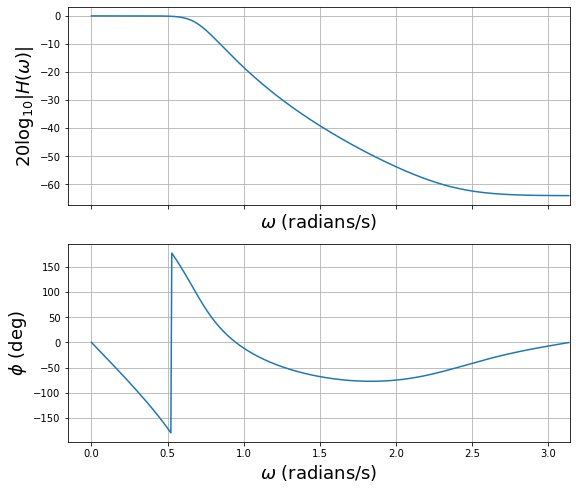

In [10]:
from __future__ import  division
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy as scp

fs = 500

b1 = [0.2871, -0.4466]
b2 = [-2.1428, 1.1444]
b3 = [1.8566, -0.6303]


a1 = [1, -1.2971, 0.6949]
a2 = [1, -1.069, 0.3699]
a3 = [1, -0.9972, 0.2570]

b = np.convolve(np.convolve(b1,a2),a3) + np.convolve(np.convolve(b2,a1),a3) + np.convolve(np.convolve(b3,a1),a2)

a = np.convolve(np.convolve(a1,a2),a3)


w,H = signal.freqz(b,a) # resposta em frequência

fig, axs = plt.subplots(2,1,sharex=True)
plt.subplots_adjust( hspace = .2 )
fig.set_size_inches((9,8))

ax=axs[0]
ax.plot(w,20*np.log10(abs(H)))
ax.set_xlabel(r'$\omega$ (radians/s)',fontsize=18)
ax.set_ylabel(r"$20 \log_{10} |H(\omega)| $",fontsize=18)
ax.grid()


ax=axs[1]
ax.plot(w,np.angle(H)/np.pi*180)
ax.set_xlabel(r'$\omega$ (radians/s)',fontsize=18)
ax.set_ylabel(r"$\phi $ (deg)",fontsize=18)
ax.set_xlim(xmax = np.pi)
ax.grid()

### Método da Transformação Bilinear

É um método não linear que se baseia na compressão de todo o eixo $j\Omega$ do plano $s$ no círculo unitário, sem sobreposição. Tem a vantagem de evitar o aliasing e manter a magnitude da resposta em frequência do filtro analógico.

É realizada mapeando $s = \frac{2}{T_d}\left(\frac{1-z^{-1}}{1+z^{-1}}\right)$, ou seja 
$$H(z) = H_c\left[\frac{2}{T_d}\left(\frac{1-z^{-1}}{1+z^{-1}}\right)\right]$$ que pode inverter para obter $$z = \frac{1 + (T_d/2)s}{1 - (T_d/2)s}$$ substituindo $s = \sigma + j\Omega$  obtemos
$$z = \frac{1+\sigma T_d/2 + j\Omega T_d/2}{1-\sigma T_d/2 - j\Omega T_d/2} $$

Pólos no lado esquerdo do plano $s$, são mapeados em pólos dentro do círculo unitário: filtros causais estáveis são mapeados em filtros causais estáveis.

Quando $s = j\Omega,$ $$z = \frac{1+j\Omega T_d/2}{1- j\Omega T_d/2},$$ $|z| = 1$ para todo $s$ no eixo $j\Omega,$ logo podemos escrever 
<p>
$$e^{j\omega} = \frac{1+\sigma T_d/2 + j\Omega T_d/2}{1-\sigma T_d/2 - j\Omega T_d/2},$$ e de $s = \frac{2}{T_d}\left(\frac{1-z^{-1}}{1+z^{-1}}\right)$ obtemos $$s = \frac{2}{T_d}\left(\frac{1-e^{-j\omega}}{1+ze^{-j\omega}}\right)$$

Fazendo $$s = \sigma + j\omega = \frac{2}{T_d}\left[\frac{2e^{-j\omega/2}(j\sin(\omega/2)}{2e^{-j\omega/2}\cos(\omega/2)} \right] = \frac{2j}{T_d}\tan(\omega/2)$$
chegamos a $$\Omega = \frac{2}{T_d}\tan(\omega_2)$$ ou $$\omega = 2 arctg(\Omega T_d/2)$$


Em resumo:
- Método não linear para comprimir todos os pontos do eixo $j\Omega$ no círculo unitário, sem sobreposição;
- Vantagem: *aliasing* é evitado, logo pode-se implementar qualquer tipo de filtro.
- Mantém-se a magnitude da resposta em frequência.
- Pontos a serem mapeados:

![title](img/tab66PauloDiniz.png)

Pode ser feito mapeando $s \rightarrow \frac{1 - z^{-1}}{1 + z^{-1}}$.

Fazendo $s = j\Omega$ e  $z = e^{j\omega}$ (representações das frequências em cada domínio, temos:
 
$$
 j\Omega \rightarrow \frac{2}{T_s}\frac{1 - e^{-j\omega}}{1 + e^{-j\omega}} = \frac{2}{T_s}\frac{e^{j\omega/2} - e^{-j\omega/2}}{e^{j\omega/2} + e^{-j\omega/2}} = j\frac{2}{T_s}\frac{\sin(\omega/2)}{\cos(\omega/2)} = j\frac{2}{T_s}\tan\frac{\omega}{2}.
$$
 e portanto:
$$
 \Omega = \frac{2}{T_s}\tan\frac{\omega}{2}
$$

Nas baixas frequências $\tan(\omega/2) \approx w/2$, logo $\Omega = \frac{1}{T_S}\omega$: magnitude do filtro é aproximadamente a mesma;

Nas altas frequências $\Omega \rightarrow \frac{2}{T}\tan(\omega/2)$, relação não linear

![title](img/fig69PauloDiniz.png)

	
Distorção nas altas frequências: *warping*.

Solução: pré-warping, fazer o mapeamento da especificação do filtro digital $\omega_i$ para a frequência analógica por $\Omega_i = \frac{2}{T_2} \tan(\omega_i/2)$

- Fazer a distorção prévia de todas as frequências especificadas no projeto de filtros
\[
\Omega_i = \frac{2}{T_2} \tan(\omega_i/2)
\]
- Obter $H_a(s)$ par o filtro desejado;
- Obter a função de transferência do filtro digital substituindo $s$ por $\frac{2}{T_s}\frac{1 - z^{-1}}{1 + z^{-1}}$ em $H_a(s)$
- Implementar o filtro digital;

**Exemplo:** Projetar um filtro passa-baixas Butterworth com uma frequência de corte de 3dB em 2kHz e atenução mínima de 15dB em 4.25kHz para uma frequência de amostragem de 10kHz.

Temos que $F_s = 10^4 Hz$, logo $T_s = 10^{-4} s$. E que $\omega_{d1} = 2\pi.2.10^3/Fs\ rad/s$ e $\omega_{d2} = 2\pi.4,5.10^3/Fs\ rad/s$.

Aplicando a pré-distorção, temos: $\Omega_{a1} = \frac{2}{T_s}\tan\frac{\omega_{d2}}{2} = 14,53\times 10^3\ rad/s$. $\Omega_{a2} = 83,31.10^3\ rad/s$.

Ou seja, $f_{a1} = 2,3kH$ e $f_{a2} = 13,3\ kHz$.

A ordem de um filtro Butterworth é obtida das expressões:
$$
1 + \left(\frac{\Omega_{a1}}{\Omega_c}\right)^{(2N)} = \frac{1}{|Hc(j\Omega_{a1})|^2}
$$
e

$$
1 + \left(\frac{\Omega_{a2}}{\Omega_c}\right)^{(2N)} = \frac{1}{|Hc(j\Omega_{a2})|^2}
$$
dividindo essas equações e manipulando chegamos a 
$$
N = \frac{log\left[ (1/|H_c(j\Omega_{a1})|^2 -1)/(|H_c(j\Omega_{a1})|^2 -1)\right]}{2\log\left(\Omega_{a1}/\Omega_{a2} \right)}
$$
e para $\Omega_1 = 2\pi 2,3kHz$ e $\Omega_2 = 2\pi 13,3 kHz$, obtém-se N obtida de $N \approx 1,6648$, logo podemos escolher $N =2$.

Com $N = 2$, usamos $s_k = \Omega_1 e^{(j\pi/2*N)*(2k+N-1)}$ para encontrar os $2N$ polos, que são 

\begin{eqnarray}
s_1 &=& -0.8886 + 0.8886i  \nonumber \\
s_2 &=&  -0.8886 - 0.8886i \nonumber \\
s_3 &=&  0.8886 - 0.8886i \nonumber \\
s_3 &=&  0.8886 + 0.8886i \nonumber
\end{eqnarray}

Considerando que a função de transferência (normalizada) pode ser escrita como
\[
H(s) = \frac{G}{\prod\limits_{i=1}^{N}(s - p_i)}
\]
sendo $p_i$ os polos do filtro analógico no lado esquerdo do plano.

Tomando $s_1$ e $s_2$ podemos encontra o ganho 
\[
G = H(0) = \prod\limits_{k=1}^{N}(-p_k) = 1.5791
\]
e finalmente fazemos
$$
H(s) =  \frac{1.5791}{s^2 + 1,6s +0,64} 
$$
e aplicando a transformação temos:
$$
H(z) = \frac{1.5791*T_s^2 - 2*1,5791T_s^2 z^{-1} + 1.5791 T_S-^2 z^{-2}}{2,8*T_s^2 + 0.64 T_s^2 z^{-1}  - 6.4T_s^2 z^{-2}}
$$
e no tempo discreto
$$
y(n) = \frac{1}{4*10^8}[1.5791x(n) - 3.158x(n-1) + 1.5791x(n-2) 
- 1.6x10^9 y(n-1) + 0.4x10^8 y(n-2)] 
$$


Usando $H(z)$ podemos verificar

Ganho DC: $\omega_dT = 0 \rightarrow\ z = 1$: |H(1)| = 1;

Frequência de 3dB: $\omega_{d1}T_s = 0,4\pi$: $|G(e^{0,4\pi j})|\ = 0,707$


### <font color='blue'> Exercício </color>

No arquivo <a href="https://drive.google.com/file/d/1VlMk69ygLX5wgbGzmwkgJCvmlXi1opx9/view?usp=sharing">sinal\_1.wav</a> foi gravado um sinal composto de soma de cossenos amostrados a uma frequência de 16 kHz. Deseja-se conhecer quantas componentes (cossenos) formam esse sinal;

Também foi solicitado um sistema que separe as componentes do sinal gravado.

Sua tarefa é atender as solicitações acima entregando um conjunto de filtros que separe as compontentes do sinal em gráficos separados (**você só dispõe de filtros IIR**);